In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
  
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial
  
AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Augmentation used for different classes. For hc and lc , flip left right was used. For mc flip left right, skew and zoom were used. sample length should be the product of length of the datasamples for a class and the number of annotations performed on that set.

In [ ]:
!pip install augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import Augmentor
# Passing the path of the image directory
p = Augmentor.Pipeline('/content/High')
  
# Defining augmentation parameters and generating 5 samples
p.flip_left_right(0.5)
#p.black_and_white(0.1)
#p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#p.rotate(0.3, 10, 10)
p.skew(0.4, 0.5)
#p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5)
p.sample(2*len(os.listdir('/content/High')))

In [ ]:
!unzip /content/drive/MyDrive/ottawa_labeled.zip

In [2]:
import os
import shutil
def make_dataset(dset):
  %cd /content/
  if dset == 'train':
      %mkdir train
  else:
      %mkdir test
  print('here')
  for img_fold in os.listdir("/content/"+dset):
    for img in os.listdir("/content/"+dset+"/"+img_fold):
      shutil.copy("/content/"+dset+"/"+img_fold+'/'+img, "/content/"+dset+"/"+img)    
  path = "/content/"+dset
  return path
  #test_path = "/content/drive/MyDrive/dataset/val"

In [10]:
train_path = make_dataset('train')
test_path = make_dataset('test')

/content
mkdir: cannot create directory ‘train’: File exists
here
/content
here


## creating data frame.Uncomment if necessary

In [3]:
import os
import pandas as pd

def create_csv(dset):
    id = []
    class_s = []
    #class_dic = {'hc': 0, 'lc': 1, 'mc': 2}
    for img_fold in os.listdir("/content/"+dset):
      for img in os.listdir("/content/"+dset+"/"+img_fold):
          id.append(img)
          class_s.append(img_fold)
    # Importing Pandas to create DataFrame
    # Creating DataFrame and Storing it in variable df

    data = {'id': id,
            'class': class_s}
    df = pd.DataFrame(data) 
    df.to_csv(dset + '_traffic.csv')
    return df

In [12]:
df_train = create_csv('train')
df_test = create_csv('test')

In [2]:
# df_train = pd.read_csv('/content/train_traffic.csv')
# df_test = pd.read_csv('/content/test_traffic.csv')

In [ ]:
print("Total number of images in the dataset: ", len(df_train))

label_count = df_train['class'].value_counts()
print(label_count)

Total number of images in the dataset:  1589
Low       777
Medium    414
High      398
Name: class, dtype: int64


If you want to use "categorical_crossentropy", the labels should be one-hot-encoded. When your labels are given as an integer, changing to "sparse_categorical_crossentropy" is required. The advantage of using "categorical_crossentropy" is that it can give you class probabilities, which might be useful in some cases. Or load with flow_from_directory, flow_from_dataframe then use class_mode='categorical'

In [3]:
import cv2
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
def convert_labels(dset, df):
  
  path = '/content/'+dset+'/'
  dataset_path = df['class']

  im_size = 300
  count = 0
  images = []
  labels = []
  y = [] 
  Y= []
  for i in dataset_path:
      data_path = path + str(i)  

      filenames = df['id'][count]

      count+=1
      #for f in filenames:
      img = cv2.imread(data_path + '/' + filenames)
      img = cv2.resize(img, (im_size, im_size))
      images.append(img)
      labels.append(i)
  images = np.array(images)

  images = images.astype('float32') / 255.0
  images.shape
 # ydf = {'id': df['id'],
 #         'class': df['class']}
  y=df['class'].values
  print(y[9], y[99], y[214])
 # ydf['id'] = y
  y_labelencoder = LabelEncoder ()
  y = y_labelencoder.fit_transform (y)
  print(y[9], y[99], y[214])
  y=y.reshape(-1,1)
  from sklearn.compose import ColumnTransformer
  ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
  # if dset == 'test':
  #       Y = ct.fit_transform(y).toarray()
  # else:
  Y = ct.fit_transform(y)
  print(Y[:5])
  #print(Y[35:])
  #images, Y = shuffle(images, Y, random_state=1)
  return images, Y

In [4]:
#This model takes input images of shape (300, 300, 3), and the input data should range [0, 255]. 
train_xx, train_yy = convert_labels('train', df_train)
test_x, test_y = convert_labels('test', df_test)


Medium Medium Medium
2 2 2
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Medium Low High
2 1 0
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
import gc
gc.collect()

48

In [ ]:
# from sklearn.model_selection import train_test_split
#train_x, xx, train_y, yy = train_test_split(train_x, train_y, test_size=0.0001, random_state=415)
# #inpect the shape of the training and testing.
# # print(train_x.shape)
# # print(train_y.shape)
# # print(test_x.shape)
# # print(test_y.shape)

In [5]:
shuffle(train_xx, train_yy, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(train_xx, train_yy, test_size=0.15, random_state=42)
# test_x, xx, test_y, yy = train_test_split(test_x, test_y, test_size=0.0001, random_state=415)

In [6]:
# Retrain the EfficientNetB3
from keras.applications.efficientnet import EfficientNetB3
NUM_CLASSES = 3
IMG_SIZE = 300
size = (IMG_SIZE, IMG_SIZE)


inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
outputs = EfficientNetB3(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)
model = tf.keras.Model(inputs, outputs)
opt = tf.keras.optimizers.Adam(learning_rate=0.0007)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(
                                         patience=14,
                                          
                                          restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('./mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
batch_size=16
STEP_SIZE_TRAIN = len(train_x)//batch_size
STEP_SIZE_VALID = len(val_x)//batch_size
 
# fit model
with tf.device('/GPU:0'):
  history = model.fit(train_x, train_y,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=(val_x, val_y),
                        validation_steps=STEP_SIZE_VALID,
                          #workers = 2,
                          #shuffle = True,
                          epochs=50, verbose=2, callbacks = [early_stopping, model_checkpoint])#])#

Epoch 1/50
84/84 - 83s - loss: 3.5193 - accuracy: 0.3879 - val_loss: 1.6986 - val_accuracy: 0.2301 - 83s/epoch - 989ms/step
Epoch 2/50
84/84 - 52s - loss: 2.1615 - accuracy: 0.4196 - val_loss: 1.4598 - val_accuracy: 0.4812 - 52s/epoch - 623ms/step
Epoch 3/50
84/84 - 53s - loss: 1.6917 - accuracy: 0.4513 - val_loss: 1.0772 - val_accuracy: 0.4812 - 53s/epoch - 628ms/step
Epoch 4/50
84/84 - 51s - loss: 1.4104 - accuracy: 0.5226 - val_loss: 1.1639 - val_accuracy: 0.2301 - 51s/epoch - 613ms/step
Epoch 5/50
84/84 - 51s - loss: 0.9624 - accuracy: 0.6248 - val_loss: 1.4590 - val_accuracy: 0.2301 - 51s/epoch - 610ms/step
Epoch 6/50
84/84 - 51s - loss: 0.8307 - accuracy: 0.6678 - val_loss: 1.3443 - val_accuracy: 0.4812 - 51s/epoch - 611ms/step
Epoch 7/50
84/84 - 53s - loss: 0.7582 - accuracy: 0.7179 - val_loss: 1.0407 - val_accuracy: 0.4519 - 53s/epoch - 635ms/step
Epoch 8/50
84/84 - 53s - loss: 0.7561 - accuracy: 0.7080 - val_loss: 0.9839 - val_accuracy: 0.4017 - 53s/epoch - 627ms/step
Epoch 9/

In [7]:
 import shutil
 shutil.copy('/content/mdl_wts.hdf5','/content/drive/MyDrive/mdl_wts.hdf5' )

'/content/drive/MyDrive/mdl_wts.hdf5'

In [ ]:
#model.save("/content/drive/MyDrive/Efficientnet_b3_Model.h5")

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy:0.9555712342262268\nValidation Accuracy: 0.7656903862953186')

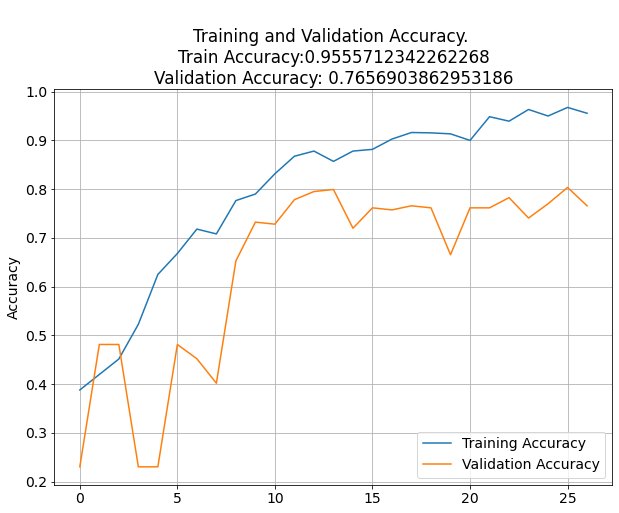

In [8]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
 
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

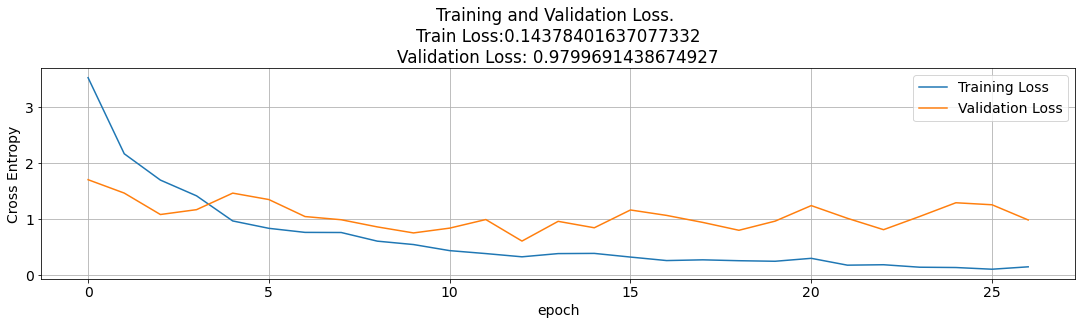

In [9]:
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
# len(test_x)

327

In [10]:
accuracy_score = model.evaluate(test_x, test_y)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
 
print("Loss: ",accuracy_score[0])

7/7 [==============================] - 4s 401ms/step - loss: 1.5145 - accuracy: 0.6250
[1.514506459236145, 0.625]
Accuracy: 62.5000%
Loss:  1.514506459236145


In [ ]:
# from tensorflow import keras
# model = keras.models.load_model('/content/drive/MyDrive/Efficientnet_b3_Model.h5')

In [ ]:
class_names = ['High', 'Low', 'Medium']
predictions = []
real_val=[]
i=0

  #for image in sample.id:
for img in df_test['id']:
    # print(img)
    # if img in df['id'][:577]:
      # img = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/dataset/test/"+img_fold+'/'+test_x)
        image = img

        class_idx = df_test['id'].tolist().index(img)
        print(class_idx)
        real_val.append(df_test['class'][class_idx])
        
        img = img = tf.keras.preprocessing.image.load_img("/content/test/"+df_test['class'][class_idx]+'/'+img)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.keras.preprocessing.image.smart_resize(img, (300, 300))
        img = tf.reshape(img, (-1, 300, 300, 3))
        prediction = model.predict(img/255)
        predictions.append(class_names[np.argmax(prediction)])
        plt.figure(figsize=[15, 10])
        img1 = cv2.imread("/content/test/"+df_test['class'][class_idx]+'/'+image)
        plt.subplot(5, 5, 1)
        plt.imshow(img1)
        plt.title(class_names[np.argmax(prediction)])
        plt.axis('off')
print(real_val)

In [ ]:
# for i in range(len(predictions)):
#   if predictions[i] == real_val[i]:
#     #print("right", predictions[i]) 
#     a=0
#   else: 
#     print(predictions[i], real_val[i])

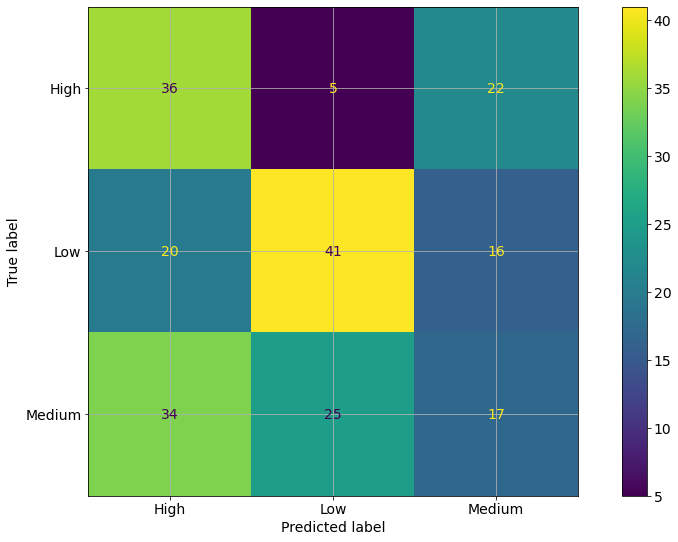

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clabels = ['High', 'Low', 'Medium']
cm = confusion_matrix(real_val, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=clabels)
cmd.plot()

## Overall Prediction on trainset of 4475 images

In [ ]:
accuracy_score = model.evaluate(train_xx, train_yy)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
 
print("Loss: ",accuracy_score[0])

140/140 [==============================] - 47s 220ms/step - loss: 0.2688 - accuracy: 0.9115
[0.2688242495059967, 0.9115083813667297]
Accuracy: 91.1508%
Loss:  0.2688242495059967
